# ISSP2170 Assignment 5 - Classification

In [11]:
%load_ext autoreload
%autoreload
import sys, os, time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
import seaborn as sns

sys.path.append('/mnt/c/Users/mtr22/Code/param_search')
import param_search as ps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Problem 1. Support vector machines

The objective is to train a support vector machine for classification applied to the Pima data set. First we will define a hyperparameter search space involving the type of SVM kernel and regularization parameters.

In [2]:
reg_space = ps.ParamSpace(
    type='SVC',
    C=[0.1, 0.5, 1.0, 5.0, 10.0],
    nu=0,
) + ps.ParamSpace(
    type='NuSVC',
    C=0,
    nu=[0.1, 0.2, 0.3, 0.4, 0.5]
)

kernel_space = ps.ParamSpace(
    kernel=['linear', 'rbf'],
    degree=1
) + ps.ParamSpace(
    kernel='poly',
    degree=[2, 3]
)

svm_space = reg_space * kernel_space
len(svm_space)

40

Train and evaluate the support vector machines in parallel with multiprocessing.

In [3]:
name = 'svm__{type}__{C:}__{nu:.2f}__{kernel}__{degree}'
cmd = 'python hw5_SVM.py --name {job_name} --type {type} --C {C} --nu {nu} --kernel {kernel} --degree {degree}'
jobs = ps.submit_local(cmd, name, svm_space, work_dir='hw-5-files')
jobs = jobs.set_index(svm_space.keys())

100%|█████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.75it/s]


Check that none of the submitted jobs had errors.

In [4]:
jobs['error'] = jobs['stderr'].map(ps.parse_stderr)
jobs[jobs['error'].astype(bool)].head()

,,,,,job_name,stdout,stderr,error
type,C,nu,kernel,degree,,,,


Check the stdout of an example job.

In [5]:
print(jobs.loc['SVC', 1.0, 0.0, 'linear', 1].stdout)

Configuring run
{
    'name': 'svm__SVC__1.0__0.00__linear__1',
    'type': 'SVC',
    'kernel': 'linear',
    'degree': 1,
    'nu': 0.0,
    'C': 1.0
}

Loading training set
   preg  plas  pres  skin  test  mass   pedi  age  class
0     5    44    62     0     0  25.0  0.587   36      0
1    10   129    76    28   122  35.9  0.280   39      0
2     4   148    60    27   318  30.9  0.150   29      1
3    13   153    88    37   140  40.6  1.174   39      0
4     1   128    48    45   194  40.5  0.613   24      1
(537, 8) (537,)

Loading test set
   preg  plas  pres  skin  test  mass   pedi  age  class
0     6    92    62    32   126  32.0  0.085   46      0
1     5   132    80     0     0  26.8  0.186   69      0
2     3   106    72     0     0  25.8  0.207   27      0
3     4    99    68    38     0  32.8  0.145   33      0
4     4    96    56    17    49  20.8  0.340   26      0
(231, 8) (231,)

Standardizing input variables
Fitting support vector machine

Train evaluations
Accuracy:

Read in the true classes, predicted classes, and predicted scores for each example.

In [7]:
def read_metrics(jobs):   
    import pandas as pd
    columns = ['data', 'y', 'yhat', 'score']
    metrics = []
    for n in jobs['job_name']:
        m = pd.read_csv(f'hw-5-files/metrics/{n}_evals.csv', names=columns, sep=' ')
        m['job_name'] = n
        metrics.append(m)
    metrics = pd.concat(metrics)
    return jobs.reset_index().merge(metrics, on='job_name')

metrics = read_metrics(jobs).set_index(svm_space.keys())
metrics.head()

job_name  \
type C   nu  kernel degree                                   
SVC  0.1 0.0 linear 1       svm__SVC__0.1__0.00__linear__1   
                    1       svm__SVC__0.1__0.00__linear__1   
                    1       svm__SVC__0.1__0.00__linear__1   
                    1       svm__SVC__0.1__0.00__linear__1   
                    1       svm__SVC__0.1__0.00__linear__1   

                                                                       stdout  \
type C   nu  kernel degree                                                      
SVC  0.1 0.0 linear 1       Configuring run\n{\n    'name': 'svm__SVC__0.1...   
                    1       Configuring run\n{\n    'name': 'svm__SVC__0.1...   
                    1       Configuring run\n{\n    'name': 'svm__SVC__0.1...   
                    1       Configuring run\n{\n    'name': 'svm__SVC__0.1...   
                    1       Configuring run\n{\n    'name': 'svm__SVC__0.1...   

                           stderr error   data    y  yhat     score  
type C   nu  kernel degree                                           
SVC  0.1 0.0 linear 1              None  train  0.0   0.0 -2.451022  
                    1              None  train  0.0   1.0  0.274993  
                    1              None  train  1.0   0.0 -0.270203  
                    1              None  train  0.0   1.0  2.106484  
                    1              None  train  1.0   0.0 -0.191747

In [12]:
def evaluate_classifier(x):
    ret = dict()
    ret['accuracy'] = accuracy_score(x['y'], x['yhat'])
    ret['roc_auc'] = roc_auc_score(x['y'], x['score'])
    ret['pr_auc'] = average_precision_score(x['y'], x['score'])
    return pd.Series(ret)

new_cols = [
    'accuracy',
    'roc_auc',
    'pr_auc',
]
agg = metrics.reset_index().groupby(svm_space.keys() + ['data']).apply(evaluate_classifier)
agg = agg.reset_index()
agg['kernel_d'] = agg['kernel'] + ' ' + agg['degree'].astype(str)
agg['C_nu'] = np.maximum(agg['C'], agg['nu'])
agg

,type,C,nu,kernel,degree,data,accuracy,roc_auc,pr_auc,kernel_d,C_nu
0,NuSVC,0.0,0.1,linear,1,test,0.354978,0.362500,0.259359,linear 1,0.1
1,NuSVC,0.0,0.1,linear,1,train,0.387337,0.379755,0.332786,linear 1,0.1
2,NuSVC,0.0,0.1,poly,2,test,0.593074,0.500000,0.340853,poly 2,0.1
3,NuSVC,0.0,0.1,poly,2,train,0.538175,0.476291,0.372866,poly 2,0.1
4,NuSVC,0.0,0.1,poly,3,test,0.467532,0.383275,0.268030,poly 3,0.1
...,...,...,...,...,...,...,...,...,...,...,...
75,SVC,10.0,0.0,poly,2,train,0.731844,0.758958,0.671099,poly 2,10.0
76,SVC,10.0,0.0,poly,3,test,0.761905,0.778521,0.563251,poly 3,10.0
77,SVC,10.0,0.0,poly,3,train,0.841713,0.907838,0.881531,poly 3,10.0
78,SVC,10.0,0.0,rbf,1,test,0.766234,0.830018,0.612913,rbf 1,10.0


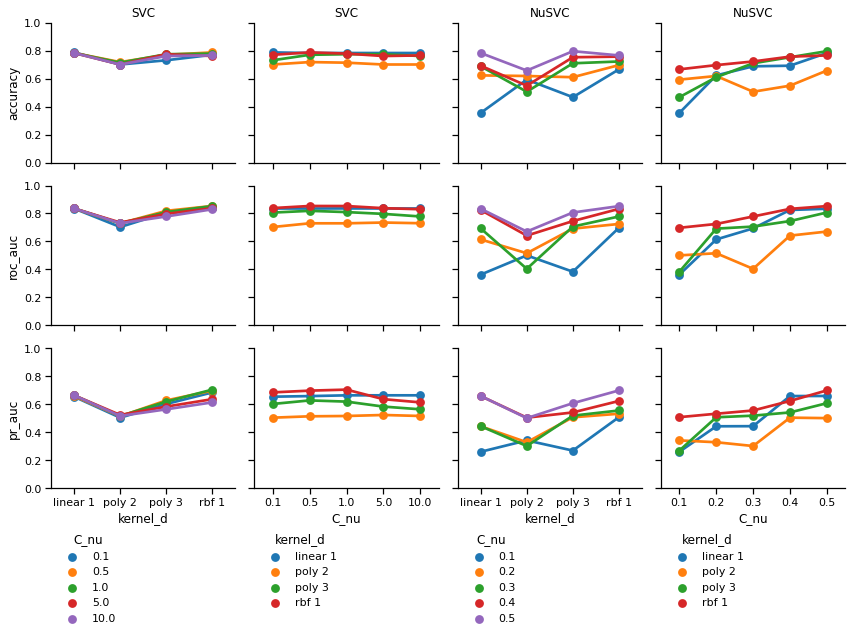

In [13]:
sns.set_context('notebook')

y = ['accuracy', 'roc_auc', 'pr_auc']
ylim = {
    'accuracy': [0.0, 1.0],
    'roc_auc':  [0.0, 1.0],
    'pr_auc':   [0.0, 1.0]
}
x = ['kernel_d', 'C_nu']

fig = ps.plot(
    agg[agg['data'] == 'test'],
    x=x, y=y, block='type',
    block_levels=['SVC', 'NuSVC'],
    ylim=ylim
)

In [15]:
agg[agg['data'] == 'test'].sort_values('accuracy', ascending=False).head()

,type,C,nu,kernel,degree,data,accuracy,roc_auc,pr_auc,kernel_d,C_nu
36,NuSVC,0.0,0.5,poly,3,test,0.796537,0.806778,0.606980,poly 3,0.5
40,SVC,0.1,0.0,linear,1,test,0.787879,0.835299,0.653526,linear 1,0.1
54,SVC,0.5,0.0,rbf,1,test,0.787879,0.853521,0.696794,rbf 1,0.5
32,NuSVC,0.0,0.5,linear,1,test,0.783550,0.833715,0.658689,linear 1,0.5
72,SVC,10.0,0.0,linear,1,test,0.783550,0.835563,0.663271,linear 1,10.0


## Problem 2 - Neural networks

In [ ]:
mlp_space = ps.ParamSpace(
    hidden_layers=[],
    activation=[],
    solver=[],
    alpha=[],
    lr_func=[],
    lr_init=[],
    max_iter=[],
)

len(mlp_space)